In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/speedingticket/Speeding_Ticket.txt
/kaggle/input/carspeed/car.mp4


# **Importing Packages and Playing Video using OpenCV**

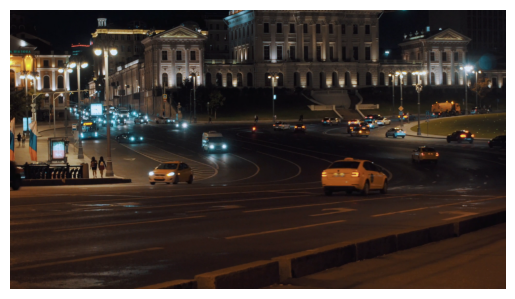

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

video_path = "/kaggle/input/carspeed/car.mp4"

cap = cv2.VideoCapture(video_path)

manual_delay = 0.01  
while True:
   
    ret, frame = cap.read()

   
    if not ret:
        break

    
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    
    plt.imshow(frame_rgb)
    plt.axis('off')  # Hide the axis
    display(plt.gcf())
    clear_output(wait=True)

    
    plt.pause(manual_delay / 1000.0) 


cap.release()

# **Detecting Motion Using OpenCV**

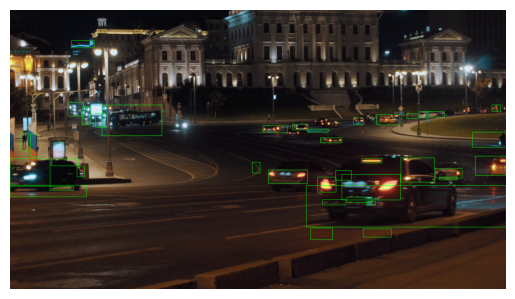

In [3]:

video_path = "/kaggle/input/carspeed/car.mp4"

cap = cv2.VideoCapture(video_path)

backSub = cv2.createBackgroundSubtractorMOG2()


max_frames = 100  


manual_delay = 1  

frame_count = 0

while frame_count < max_frames:
    
    ret, frame = cap.read()
    if not ret:
        break
    
    fgMask = backSub.apply(frame)
    
   
    contours, _ = cv2.findContours(fgMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Loop through the contours
    for contour in contours:
        # Get the bounding box of the contour
        x, y, w, h = cv2.boundingRect(contour)
        
        # Define a minimum area threshold to filter small contours
        min_area = 1000
        if cv2.contourArea(contour) > min_area:
            # Draw a rectangle around the detected object
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    # Convert the frame to RGB (OpenCV uses BGR by default)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Display the frame using matplotlib
    plt.imshow(frame_rgb)
    plt.axis('off')  # Hide axis
    display(plt.gcf())
    clear_output(wait=True)

    # Introduce a small delay to control the frame rate
    plt.pause(manual_delay / 1000.0)  # Pause for the manual delay in seconds

    # Increment the frame counter
    frame_count += 1

# Release the video capture object
cap.release()

# **Building Car Detection System with OpenCV, FASTCNN


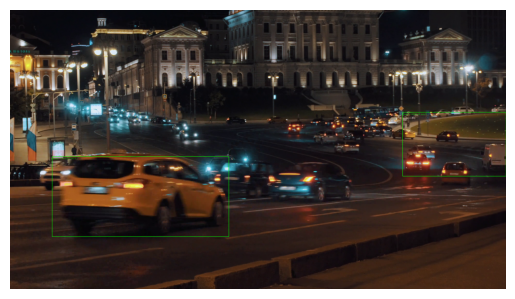

In [4]:
import numpy as np
import torch
import torchvision
import math


model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(weights='SSDLite320_MobileNet_V3_Large_Weights.COCO_V1')
model.eval()


confidence_threshold = 0.5

frame_rate = 12.5
ppm = 8.8

speed_limit = 50  # km/h
fine_amount = 25  # $

def estimate_speed(location1, location2, ppm, fps):
    d_pixels = math.sqrt((location2[0] - location1[0]) ** 2 + (location2[1] - location1[1]) ** 2)
    d_meter = d_pixels / ppm
    speed = d_meter * fps * 3.6  # Convert to km/h
    return speed


def detect_cars(frame, frame_rate, ppm):
    global pos_list_prev

    # Convert the frame to a tensor
    img_tensor = torchvision.transforms.ToTensor()(frame)

    # Use the pre-trained model for object detection
    with torch.no_grad():
        predictions = model([img_tensor])

    # Loop through the detected objects
    for pred, score in zip(predictions[0]["boxes"], predictions[0]["scores"]):
        x1, y1, x2, y2 = map(int, pred)
        if score >= confidence_threshold:
            # Draw a bounding box around the detected car
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Calculate the centroid of the bounding box
            centroid_x = (x1 + x2) / 2
            centroid_y = (y1 + y2) / 2
            pos_list = [centroid_x, centroid_y]

            # Estimate the speed if the previous position is available
            if pos_list_prev is not None:
                speed = estimate_speed(pos_list_prev, pos_list, ppm, frame_rate)
                if speed >= speed_limit:
                    issue_speeding_ticket(speed)
                    print("Speeding Ticket Issued")
            else:
                speed = 0

            # Display the estimated speed on the frame
            cv2.putText(frame, f'Speed: {speed:.2f} km/h', (x1, y1 + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

            # Update the previous position
            pos_list_prev = pos_list

    return frame

# Function to issue a speeding ticket and save the details in a text file
def issue_speeding_ticket(speed):
    filename = "Speeding_Ticket.txt"
    with open(filename, "a") as file:
        file.write("Speeding Ticket!\n")
        file.write(f"Detected Speed: {speed:.2f} km/h\n")
        file.write(f"Fine Amount: ${fine_amount}\n")
        file.write("\n")

# Open the video file
cap = cv2.VideoCapture("/kaggle/input/carspeed/car.mp4")

if not cap.isOpened():
    print('Error: unable to load the video')
    exit()

# Initialize the previous position list
pos_list_prev = None

# Set the maximum number of frames to process
max_frames = 10  # Limit the number of frames to process

# Process the video frames
frame_count = 0
while cap.isOpened() and frame_count < max_frames:
    ret, frame = cap.read()
    if not ret:
        break

    # Detect cars, estimate their speed, and issue speeding tickets
    processed_frame = detect_cars(frame, frame_rate, ppm)

    # Convert the frame to RGB (OpenCV uses BGR by default)
    frame_rgb = cv2.cvtColor(processed_frame, cv2.COLOR_BGR2RGB)

    # Display the frame using matplotlib
    plt.imshow(frame_rgb)
    plt.axis('off')  # Hide axis
    display(plt.gcf())
    clear_output(wait=True)

    frame_count += 1

# Release the video capture object
cap.release()